In [17]:
import matplotlib.pyplot as plt
import autograd.numpy as np
import numpy.linalg as linalg
from autograd import grad
import scipy.stats as st

In [35]:
means = [np.asarray([1,-4]), np.asarray([-2,2])]
covs  = [np.asarray([[2.,-0.5,],[-0.5,2]]),np.asarray([[2,0.5],[0.5,2]])]
weights = [0.5,0.5]

# checking for pos def
for cov in covs:
    _ = linalg.cholesky(cov)

In [36]:
def create_neg_log_prob(means, covs,weights):
    
    def negative_log_prob(x):
        gs = []
        N  = means[0].shape[0]
        for mean,cov in zip(means,covs):
            m = (x-mean)
            _, det= np.linalg.slogdet(cov)
            gs+=[-0.5*np.dot(m,np.dot(cov,m))-N/2.*np.log(2*np.pi)-N*det]
        res = gs[0]+weights[0]
        for ii, w in enumerate(weights[1::]):
            res=np.logaddexp(res,w+gs[ii+1])
        return -res
    return negative_log_prob

In [37]:
negative_log_prob = create_neg_log_prob(means,covs,weights)

In [38]:
negative_log_prob([0.,0.])

9.981386486047132

In [39]:
grad(negative_log_prob)

<function autograd.wrap_util.unary_to_nary.<locals>.nary_operator.<locals>.nary_f(*args, **kwargs)>

In [40]:
def hamiltonian_monte_carlo(n_samples, negative_log_prob, initial_position, path_len=1, step_size=0.5):
    """Run Hamiltonian Monte Carlo sampling.

    Parameters
    ----------
    n_samples : int
        Number of samples to return
    negative_log_prob : callable
        The negative log probability to sample from
    initial_position : np.array
        A place to start sampling from.
    path_len : float
        How long each integration path is. Smaller is faster and more correlated.
    step_size : float
        How long each integration step is. Smaller is slower and more accurate.

    Returns
    -------
    np.array
        Array of length `n_samples`.
    """
    # autograd magic
    dVdq = grad(negative_log_prob)

    # collect all our samples in a list
    samples = [initial_position]

    # Keep a single object for momentum resampling
    momentum = st.norm(0, 1)

    # If initial_position is a 10d vector and n_samples is 100, we want
    # 100 x 10 momentum draws. We can do this in one call to momentum.rvs, and
    # iterate over rows
    size = (n_samples,) + initial_position.shape[:1]
    for p0 in momentum.rvs(size=size):
        # Integrate over our path to get a new position and momentum
        q_new, p_new = leapfrog(
            samples[-1],
            p0,
            dVdq,
            path_len=path_len,
            step_size=step_size,
        )

        # Check Metropolis acceptance criterion
        start_log_p = negative_log_prob(samples[-1]) - np.sum(momentum.logpdf(p0))
        new_log_p = negative_log_prob(q_new) - np.sum(momentum.logpdf(p_new))
        if np.log(np.random.rand()) < start_log_p - new_log_p:
            samples.append(q_new)
        else:
            samples.append(np.copy(samples[-1]))

    return np.array(samples[1:])

In [41]:

def leapfrog(q, p, dVdq, path_len, step_size):
    """Leapfrog integrator for Hamiltonian Monte Carlo.

    Parameters
    ----------
    q : np.floatX
        Initial position
    p : np.floatX
        Initial momentum
    dVdq : callable
        Gradient of the velocity
    path_len : float
        How long to integrate for
    step_size : float
        How long each integration step should be

    Returns
    -------
    q, p : np.floatX, np.floatX
        New position and momentum
    """
    q, p = np.copy(q), np.copy(p)

    p -= step_size * dVdq(q) / 2  # half step
    for _ in range(int(path_len / step_size) - 1):
        q += step_size * p  # whole step
        p -= step_size * dVdq(q)  # whole step
    q += step_size * p  # whole step
    p -= step_size * dVdq(q) / 2  # half step

    # momentum flip at end
    return q, -p


In [46]:
samples = hamiltonian_monte_carlo(n_samples=10000, negative_log_prob=negative_log_prob, initial_position=np.asarray([1.,-4.]))

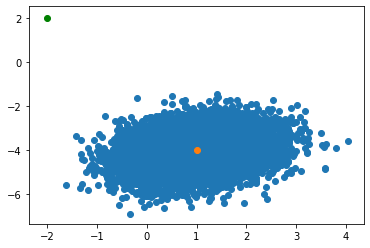

In [47]:
plt.scatter(samples[1000:,0],samples[1000:,1])
plt.scatter(means[0][0], means[0][1])
plt.scatter(means[1][0], means[1][1], color='g')
plt.show()